<a href="https://www.kaggle.com/code/zoetsekas/ensemble-of-xgboost-lightgbm-and-pytorch?scriptVersionId=252461181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Ensemble Model Training Pipeline for Personality Prediction

This notebook walks through a complete machine learning pipeline to predict personality type (Introvert/Extrovert) based on behavioral data. The pipeline includes:

1.  **Exploratory Data Analysis (EDA):** Initial analysis and visualization of the data, including a baseline model.
2.  **Data Cleaning:** Removing duplicates and potentially mislabeled samples identified by the baseline model.
3.  **Feature Engineering:** Creation of new features (interactions, bins, clusters, and groupby stats) to improve model performance.
4.  **Feature Selection:** Removing highly correlated features and selecting the top K-best features.
5.  **Independent Model Tuning:** Using Ray Tune and Optuna to find the best hyperparameters for three separate models (XGBoost, LightGBM, and a PyTorch Neural Network).
6.  **Stacking Ensemble:** Generating out-of-fold (OOF) predictions from the tuned base models to use as meta-features.
7.  **Meta-Model Training & Prediction:** Training a final, simpler model on the original and meta-features to generate the final predictions.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
import ray
from ray import tune, air
from ray.tune import TuneConfig
from ray.tune.tuner import Tuner
from ray.tune.search.optuna import OptunaSearch
from optuna.samplers import TPESampler
from ray.tune.logger import TBXLoggerCallback
import os
from itertools import combinations
from tqdm.auto import tqdm

## 1. Environment Setup and GPU Checks

In [3]:
# --- Environment Variable to Suppress Warnings ---
os.environ['RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS'] = '0'


def check_gpu_with_pytorch():
    """Checks if PyTorch can access and use the GPU, printing the status."""
    print("Performing GPU check for PyTorch...")
    if torch.cuda.is_available():
        print(f"✅ GPU check successful. PyTorch can access GPU: {torch.cuda.get_device_name(0)}")
        return True
    else:
        print("❌ GPU check FAILED. PyTorch could not find a CUDA-enabled GPU.")
        return False

def check_gpu_with_xgboost():
    """Checks if XGBoost can access and use the GPU, printing the status."""
    print("Performing GPU check for XGBoost...")
    try:
        xgb.train({'device': 'cuda'}, xgb.DMatrix(np.random.rand(10, 2), label=np.random.randint(0, 2, 10)), 1)
        print("✅ GPU check successful. XGBoost can access the GPU.")
        return True
    except xgb.core.XGBoostError:
        print("❌ GPU check FAILED. XGBoost could not utilize the GPU.")
        return False

## 2. PyTorch Neural Network Definition

In [4]:
class Net(nn.Module):
    """A dynamically configurable multi-layer perceptron for binary classification."""
    def __init__(self, input_dim, n_layers, n_nodes, dropout_rate, activation_fn):
        """
        Initializes the neural network.

        Args:
            input_dim (int): The number of input features.
            n_layers (int): The number of hidden layers.
            n_nodes (int): The number of nodes in each hidden layer.
            dropout_rate (float): The dropout rate to apply after each hidden layer.
            activation_fn (str): The name of the torch.nn activation function to use.
        """
        super(Net, self).__init__()
        layers = []
        act_fn = getattr(nn, activation_fn)()
        layers.append(nn.Linear(input_dim, n_nodes))
        layers.append(act_fn)
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(act_fn)
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(n_nodes, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """Defines the forward pass of the neural network."""
        return self.network(x)

## 3. Data Processing, EDA, and Feature Engineering Functions

In [5]:
def perform_eda(df, stage="Initial"):
    """
    Performs and prints basic Exploratory Data Analysis on the dataframe.

    Args:
        df (pd.DataFrame): The dataframe to analyze.
        stage (str): A string to identify the stage of EDA (e.g., "Initial", "Cleaned").
    """
    print(f"\n--- {stage} Exploratory Data Analysis ---")
    print("\nDataset Info:")
    df.info()
    print("\nDescriptive Statistics:")
    print(df.describe())
    print("\nPersonality Distribution:")
    print(df['Personality'].value_counts(normalize=True))
    
    # Visualize the correlation matrix of the original features
    print("\nCorrelation Matrix:")
    eda_df = df.copy()
    for col in eda_df.columns:
        if eda_df[col].dtype == 'object':
            if eda_df[col].isnull().any():
                eda_df[col] = eda_df[col].fillna(eda_df[col].mode()[0])
            eda_df[col] = LabelEncoder().fit_transform(eda_df[col])
    corr_matrix = eda_df.drop('id', axis=1).corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title(f'{stage} Correlation Matrix of Features')
    plt.savefig(f'{stage.lower()}_correlation_matrix.png')
    print(f"{stage} correlation matrix plot saved to {stage.lower()}_correlation_matrix.png")
    plt.show()

def analyze_and_clean_with_baseline(df):
    """
    Trains a baseline model to find and remove potentially mislabeled data.

    Args:
        df (pd.DataFrame): The training dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe with suspicious labels removed.
    """
    print("\n--- Baseline Model Analysis and Cleaning ---")
    baseline_df = preprocess_data(df.copy())
    X = baseline_df.drop(['id', 'Personality'], axis=1)
    y = LabelEncoder().fit_transform(baseline_df['Personality'])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    baseline_model = LogisticRegression(random_state=42)
    baseline_model.fit(X_scaled, y)
    y_hat = baseline_model.predict_proba(X_scaled)[:, 1]

    # Identify samples where the model is confident in a prediction that contradicts the label
    exclude_these = ((y == 1) & (y_hat < 0.25)) | ((y == 0) & (y_hat > 0.85))
    exclude_indices = df.index[exclude_these]
    
    print(f"Identified {len(exclude_indices)} samples to remove based on baseline model confidence.")
    
    cleaned_df = df.drop(exclude_indices).reset_index(drop=True)
    print(f"Original shape: {df.shape}, Cleaned shape: {cleaned_df.shape}")
    
    # --- New Confusion Dots and ROC Curve Plot ---
    y_thresh = 0.5
    ysframe = pd.DataFrame([y, y_hat], index=['y', 'y_prob']).transpose()
    ysframe['y (blurred)'] = ysframe['y'] + 0.1 * np.random.randn(len(ysframe))

    # Plot the real y (blurred) vs the predicted probability
    ysframe.plot.scatter('y_prob', 'y (blurred)', figsize=(10, 4),
                         s=2, xlim=(0.0, 1.0), ylim=(1.8, -0.8), alpha=0.35)
    plt.plot([0.0, y_thresh], [0.0, 0.0], '-', color='green', linewidth=3)
    plt.plot([y_thresh, y_thresh], [0.0, 1.0], '-', color='gray', linewidth=2)
    plt.plot([y_thresh, 1.0], [1.0, 1.0], '-', color='green', linewidth=3)
    plt.title("Confusion-dots Plot: Baseline Model", fontsize=16)
    ythr2 = y_thresh / 2.0
    plt.text(ythr2 - 0.03, 1.52, "FN", fontsize=16, color='red')
    plt.text(ythr2 + 0.5 - 0.03, 1.52, "TP", fontsize=16, color='green')
    plt.text(ythr2 - 0.03, -0.50, "TN", fontsize=16, color='green')
    plt.text(ythr2 + 0.5 - 0.03, -0.50, "FP", fontsize=16, color='red')
    plt.savefig("baseline_confusion_dots.png")
    print("Baseline confusion dots plot saved to baseline_confusion_dots.png")
    plt.show()

    # Make the ROC plot
    fpr, tpr, _ = roc_curve(y, y_hat)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5)) # Create a new figure for the ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Baseline Model')
    display.plot()
    plt.plot([0., 1.], [0., 1.], c='gray', alpha=0.3)
    plt.title("Baseline Model ROC Curve")
    plt.savefig("baseline_roc_curve.png")
    print("Baseline ROC curve plot saved to baseline_roc_curve.png")
    plt.show()
    
    return cleaned_df

def drop_duplicates(df):
    """Checks for and removes duplicate rows from the dataframe."""
    print("\n--- Dropping Duplicates ---")
    print(f"Original shape: {df.shape}")
    df_cleaned = df.drop_duplicates()
    print(f"Shape after dropping duplicates: {df_cleaned.shape}")
    print(f"Removed {df.shape[0] - df_cleaned.shape[0]} duplicate rows.")
    return df_cleaned

def plot_individual_features(df):
    """Creates and saves a pairplot of numerical features, colored by Personality."""
    print("\n--- Creating Pairplot of Numerical Features ---")
    numerical_features = df.select_dtypes(include=np.number).columns.tolist()
    if 'id' in numerical_features:
        numerical_features.remove('id')
    
    # Create a dataframe for the pairplot
    pairplot_df = df[numerical_features + ['Personality']]
    
    sns.pairplot(pairplot_df, hue='Personality', diag_kind='kde')
    plt.suptitle('Pairplot of Numerical Features by Personality', y=1.02)
    plt.savefig('eda_pairplot.png')
    print("Pairplot saved to eda_pairplot.png")
    plt.show()


def select_features_by_correlation(df, threshold=0.9):
    """Identifies and returns a list of highly correlated features to drop."""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"\nFound {len(to_drop)} features to drop with correlation > {threshold}: {to_drop}")
    return to_drop

def select_k_best_features(X, y, X_test, k=20):
    """Selects the top k features using SelectKBest."""
    print(f"\n--- Selecting Top {k} Features using SelectKBest ---")
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    
    # Get the columns to keep
    cols_to_keep = selector.get_support(indices=True)
    X_selected = X.iloc[:, cols_to_keep]
    X_test_selected = X_test.iloc[:, cols_to_keep]
    
    print(f"Selected {len(X_selected.columns)} features: {X_selected.columns.tolist()}")
    return X_selected, X_test_selected

def preprocess_data(df):
    """Preprocesses the data by handling NaNs and encoding categorical features."""
    df_copy = df.copy()
    for col in ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    for col in ['Stage_fear', 'Drained_after_socializing']:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
    for col in ['Stage_fear', 'Drained_after_socializing']:
        if df_copy[col].dtype == 'object':
            df_copy[col] = LabelEncoder().fit_transform(df_copy[col])
    return df_copy

def feature_engineer(df):
    """Creates new interaction, ratio, and binned features."""
    df_copy = df.copy()
    df_copy['Social_Interaction_Score'] = df_copy['Social_event_attendance'] * df_copy['Friends_circle_size']
    df_copy['Alone_vs_Social_Ratio'] = df_copy['Time_spent_Alone'] / (df_copy['Social_event_attendance'] + 1)
    
    # Binning Features
    df_copy['Time_Alone_Bin'] = pd.qcut(df_copy['Time_spent_Alone'], q=4, labels=False, duplicates='drop')
    df_copy['Friends_Circle_Bin'] = pd.qcut(df_copy['Friends_circle_size'], q=4, labels=False, duplicates='drop')
    df_copy['Post_Frequency_Bin'] = pd.qcut(df_copy['Post_frequency'], q=4, labels=False, duplicates='drop')
    return df_copy

def add_cluster_features(train_df, test_df, features, n_clusters=4):
    """Adds a new feature based on K-Means clustering."""
    print(f"\nCreating user clusters with K-Means (k={n_clusters})...")
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_df['User_Cluster'] = kmeans.fit_predict(train_scaled)
    test_df['User_Cluster'] = kmeans.predict(test_scaled)
    return train_df, test_df

def add_groupby_features(train_df, test_df):
    """Creates groupby aggregate features."""
    print("\nAdding groupby aggregate features...")
    
    groupby_cols = ['Time_Alone_Bin', 'Friends_Circle_Bin', 'Post_Frequency_Bin', 'Stage_fear', 'Drained_after_socializing', 'User_Cluster']
    agg_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
    
    for group_col in tqdm(groupby_cols, desc="Groupby Features"):
        agg_stats = train_df.groupby(group_col)[agg_cols].agg(['mean', 'std', 'min', 'max']).reset_index()
        
        # Create unique column names to avoid collisions
        new_cols = [group_col]
        for col in agg_stats.columns.levels[0]:
            if col == group_col:
                continue
            for stat in agg_stats.columns.levels[1]:
                if stat == '':
                    continue
                new_cols.append(f'{group_col}_{col}_{stat}')
        agg_stats.columns = new_cols
        
        train_df = pd.merge(train_df, agg_stats, on=group_col, how='left')
        test_df = pd.merge(test_df, agg_stats, on=group_col, how='left')
        
        # Fill NaNs in test set after the merge
        for col in new_cols:
            if col != group_col:
                median_val = train_df[col].median()
                test_df[col] = test_df[col].fillna(median_val)

    return train_df, test_df

## 4. Out-of-Fold (OOF) Prediction Generation Functions

In [6]:
def generate_xgb_oof(config, X, y, X_test):
    """Generates out-of-fold predictions for XGBoost."""
    print("\n--- Generating OOF predictions for XGBoost ---")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds_list = []
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc="XGB OOF Folds")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val)
        dtest = xgb.DMatrix(X_test)
        params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42 + fold, 'tree_method': 'hist', 'device': 'cuda', 'scale_pos_weight': scale_pos_weight, **config}
        model = xgb.train(params, dtrain, 1000, evals=[(dtrain, 'train')], early_stopping_rounds=50, verbose_eval=False)
        oof_preds[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration))
        test_preds_list.append(model.predict(dtest, iteration_range=(0, model.best_iteration)))
    return oof_preds, np.mean(test_preds_list, axis=0)

def lgb_accuracy(y_pred, y_true):
    """Custom accuracy metric for LightGBM."""
    labels = y_true.get_label()
    return 'accuracy', accuracy_score(labels, np.round(y_pred)), True
    
def generate_lgb_oof(config, X, y, X_test):
    """Generates out-of-fold predictions for LightGBM."""
    print("\n--- Generating OOF predictions for LightGBM ---")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds_list = []
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc="LGB OOF Folds")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        params = {'objective': 'binary', 'metric': 'None', 'random_state': 42 + fold, 'device': 'gpu', 'verbose': -1, 'scale_pos_weight': scale_pos_weight, **config}
        model = lgb.train(
            params, 
            dtrain, 
            1000, 
            valid_sets=[dval], 
            valid_names=['eval'], 
            feval=lgb_accuracy, 
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        test_preds_list.append(model.predict(X_test, num_iteration=model.best_iteration))
    return oof_preds, np.mean(test_preds_list, axis=0)

def generate_nn_oof(config, X, y, X_test):
    """Generates out-of-fold predictions for the PyTorch Neural Network."""
    print("\n--- Generating OOF predictions for PyTorch NN ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds_list = []
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc="NN OOF Folds")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1))
        val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32))
        test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32))
        train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
        test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

        model = Net(X.shape[1], config['n_layers'], config['n_nodes'], config['dropout_rate'], config['activation']).to(device)
        pos_weight_tensor = torch.tensor([scale_pos_weight], device=device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        optimizer_class = getattr(optim, config['optimizer'])
        optimizer = optimizer_class(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

        for _ in range(25): # More epochs for OOF generation
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        model.eval()
        fold_oof_preds = []
        with torch.no_grad():
            for inputs in val_loader:
                outputs = model(inputs[0].to(device))
                fold_oof_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        oof_preds[val_idx] = np.array(fold_oof_preds).flatten()

        fold_test_preds = []
        with torch.no_grad():
            for inputs in test_loader:
                outputs = model(inputs[0].to(device))
                fold_test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        test_preds_list.append(np.array(fold_test_preds).flatten())
        
    return oof_preds, np.mean(test_preds_list, axis=0)

## 5. Ray Tune Training Functions

In [7]:
def train_xgb_cv(config, data):
    """Ray Tune trainable function for XGBoost CV."""
    X, y, scale_pos_weight = data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'scale_pos_weight': scale_pos_weight, **config}
        model = xgb.train(params, dtrain, 1000, evals=[(dval, 'eval')], early_stopping_rounds=50, verbose_eval=False)
        preds = model.predict(dval, iteration_range=(0, model.best_iteration))
        accuracies.append(accuracy_score(y_val, np.round(preds)))
    tune.report({"accuracy": np.mean(accuracies)})

def train_lgb_cv(config, data):
    """Ray Tune trainable function for LightGBM CV."""
    X, y, scale_pos_weight = data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        params = {'objective': 'binary', 'metric': 'None', 'device': 'gpu', 'verbose': -1, 'scale_pos_weight': scale_pos_weight, **config}
        model = lgb.train(params, dtrain, 1000, valid_sets=[dval], valid_names=['eval'], feval=lgb_accuracy, callbacks=[lgb.early_stopping(50, verbose=False)])
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        accuracies.append(accuracy_score(y_val, np.round(preds)))
    tune.report({"accuracy": np.mean(accuracies)})

def train_nn_cv(config, data):
    """Ray Tune trainable function for PyTorch NN CV."""
    X, y, scale_pos_weight = data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1))
        val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1))
        train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
        model = Net(X.shape[1], config['n_layers'], config['n_nodes'], config['dropout_rate'], config['activation']).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scale_pos_weight], device=device))
        optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        for _ in range(20):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        model.eval()
        preds_list = []
        with torch.no_grad():
            for inputs, _ in val_loader:
                outputs = model(inputs.to(device))
                preds_list.extend(torch.sigmoid(outputs).cpu().numpy())
        accuracies.append(accuracy_score(y_val, np.round(preds_list)))
    tune.report({"accuracy": np.mean(accuracies)})

## 6. Data Loading

In [8]:
print("--- Loading Data ---")
train_df = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

--- Loading Data ---


## 7. Data Exploratory Analysis


--- Dropping Duplicates ---
Original shape: (18524, 9)
Shape after dropping duplicates: (18524, 9)
Removed 0 duplicate rows.

--- Creating Pairplot of Numerical Features ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Pairplot saved to eda_pairplot.png


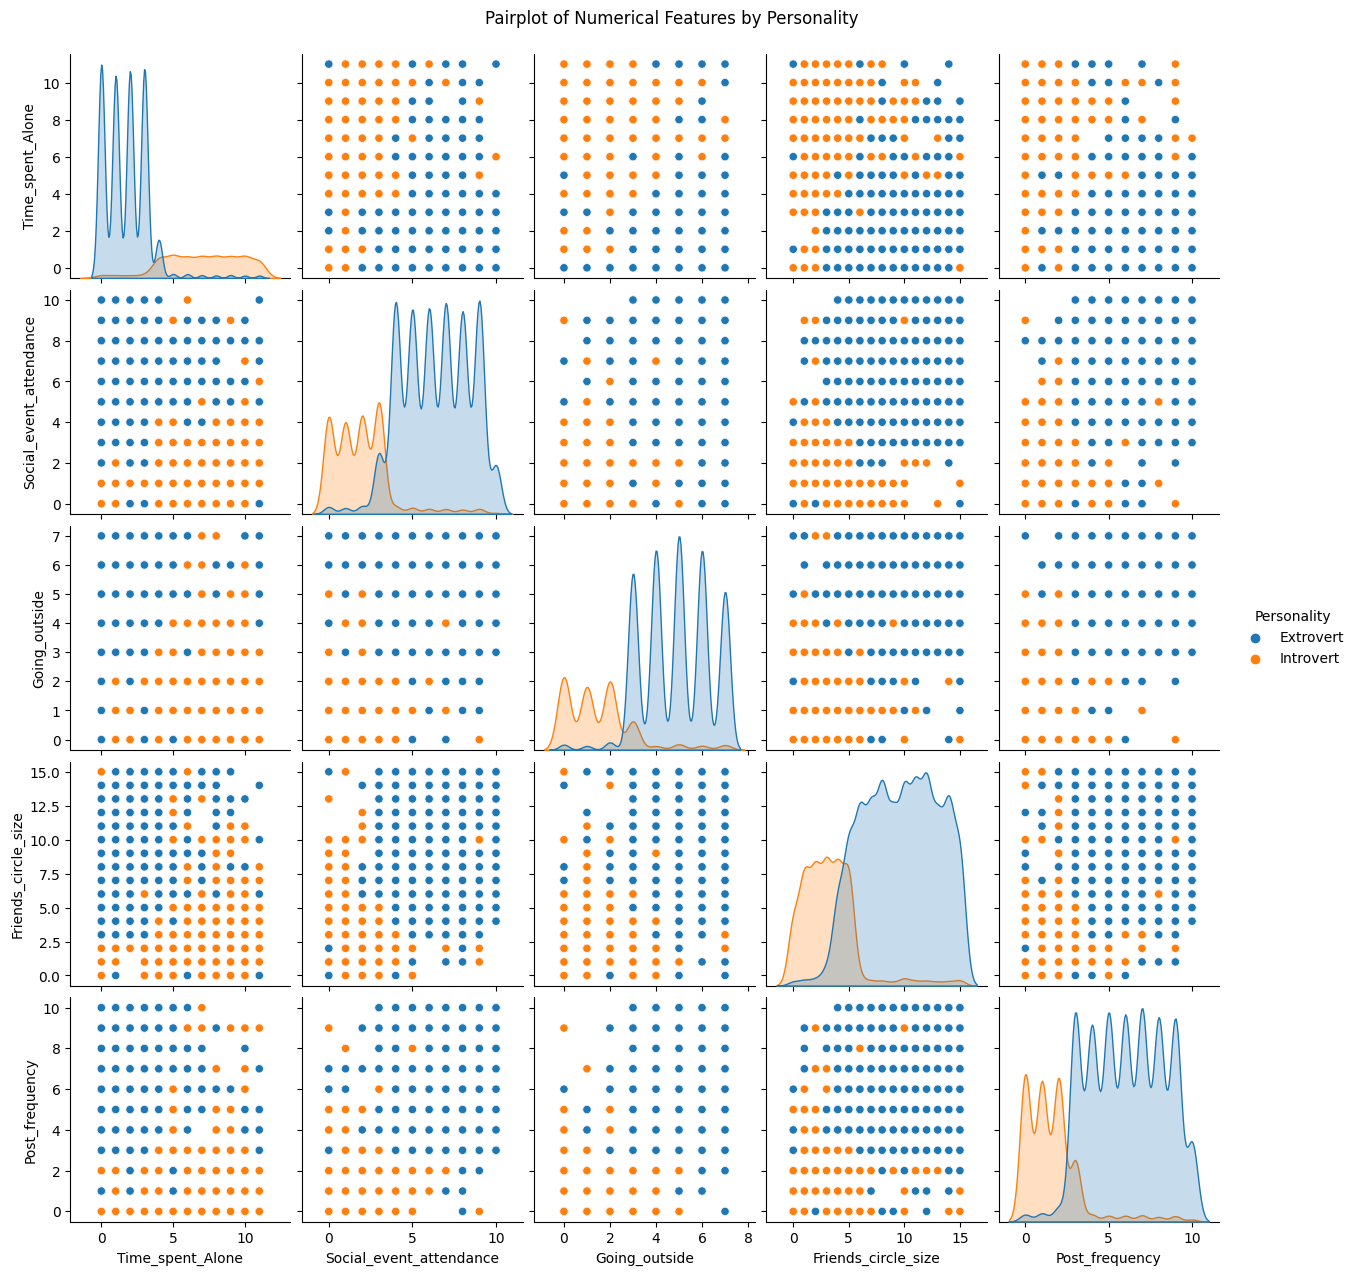


--- Initial Exploratory Data Analysis ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB

Descriptive Statistics:
                 id  Time_spent_Alone  Social_event_attendance  Going_outside  \
count  18524.000000      17334.000000             

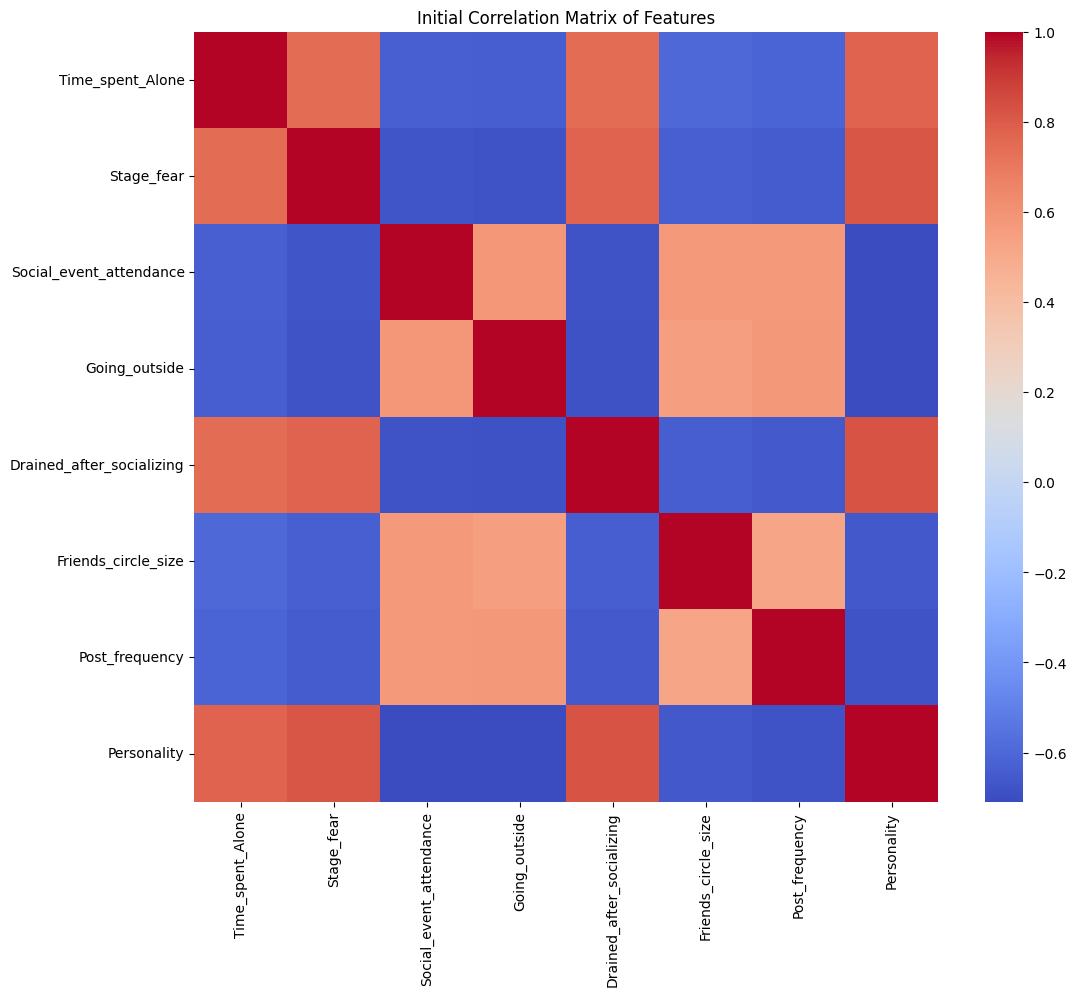


--- Baseline Model Analysis and Cleaning ---
Identified 535 samples to remove based on baseline model confidence.
Original shape: (18524, 9), Cleaned shape: (17989, 9)
Baseline confusion dots plot saved to baseline_confusion_dots.png


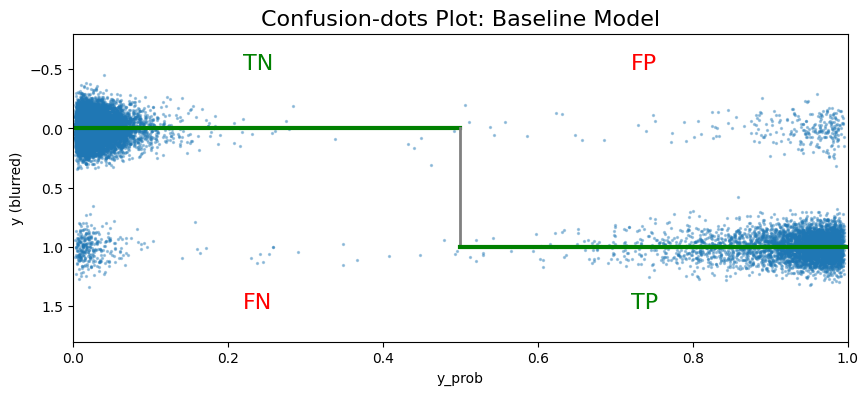

Baseline ROC curve plot saved to baseline_roc_curve.png


<Figure size 500x500 with 0 Axes>

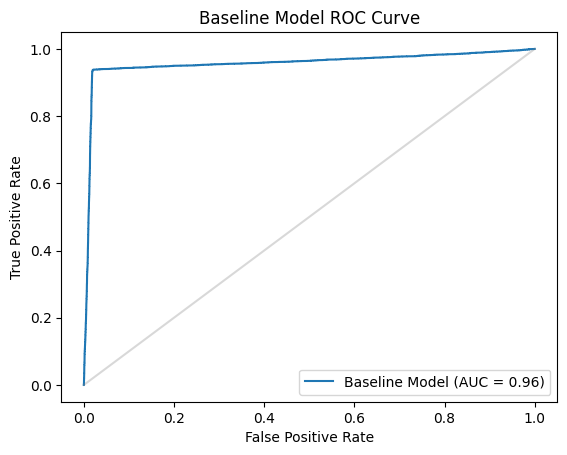


--- Cleaned Exploratory Data Analysis ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17989 entries, 0 to 17988
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         17989 non-null  int64  
 1   Time_spent_Alone           16838 non-null  float64
 2   Stage_fear                 16134 non-null  object 
 3   Social_event_attendance    16830 non-null  float64
 4   Going_outside              16550 non-null  float64
 5   Drained_after_socializing  16867 non-null  object 
 6   Friends_circle_size        16960 non-null  float64
 7   Post_frequency             16753 non-null  float64
 8   Personality                17989 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.2+ MB

Descriptive Statistics:
                 id  Time_spent_Alone  Social_event_attendance  Going_outside  \
count  17989.000000      16838.000000             

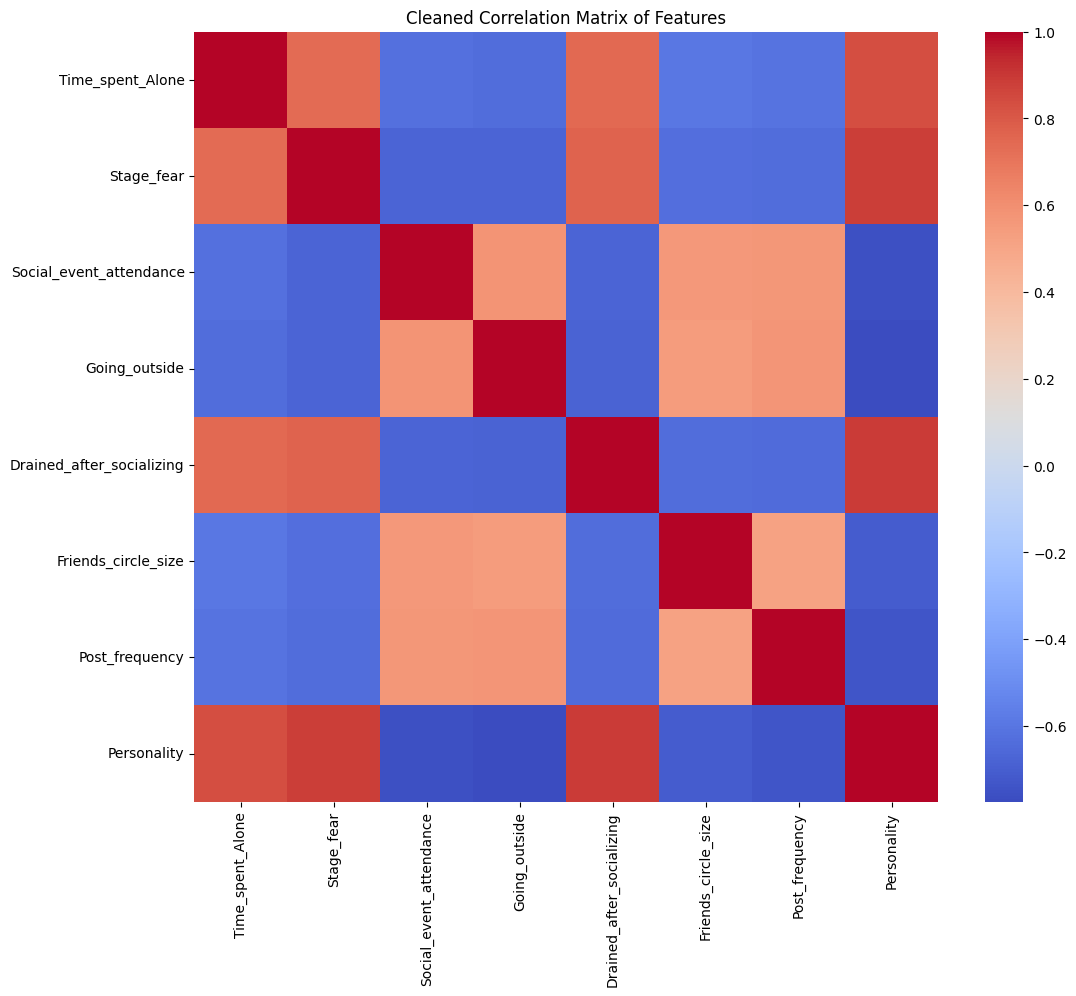

In [9]:
# --- Initial Data Cleaning and EDA ---
train_df = drop_duplicates(train_df)
plot_individual_features(train_df)
perform_eda(train_df, stage="Initial")

# --- Clean data using baseline model ---
cleaned_train_df = analyze_and_clean_with_baseline(train_df)
    
# --- Re-run EDA on cleaned data ---
perform_eda(cleaned_train_df, stage="Cleaned")

## 8. Main Execution Block

In [10]:
def main():
    """Main function to run the entire pipeline."""
    if not check_gpu_with_pytorch() or not check_gpu_with_xgboost():
        return
        
    # --- Create and run the preprocessing and feature engineering pipeline ---
    print("\n--- Starting Preprocessing and Feature Engineering Pipeline ---")
    preprocessor = Pipeline(steps=[
        ('preprocess', FunctionTransformer(preprocess_data)),
        ('feature_engineer', FunctionTransformer(feature_engineer))
    ])
    
    processed_train_df = preprocessor.fit_transform(cleaned_train_df)
    processed_test_df = preprocessor.transform(test_df)
    
    cluster_features = [
        'Time_spent_Alone', 'Friends_circle_size', 'Post_frequency',
        'Social_Interaction_Score', 'Alone_vs_Social_Ratio'
    ]
    processed_train_df, processed_test_df = add_cluster_features(processed_train_df, processed_test_df, cluster_features)
    
    processed_train_df, processed_test_df = add_groupby_features(processed_train_df, processed_test_df)
    
    le = LabelEncoder()
    le.fit(processed_train_df['Personality'])
    X = processed_train_df.drop(['id', 'Personality'], axis=1)
    y = pd.Series(le.transform(processed_train_df['Personality']), index=X.index)
    X_test = processed_test_df.drop('id', axis=1)
    X_test = X_test[X.columns]

    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
    ray.init(num_gpus=torch.cuda.device_count(), ignore_reinit_error=True)

    xgb_search_space = {"eta": tune.loguniform(1e-4, 1e-1), "max_depth": tune.randint(3, 10)}
    lgb_search_space = {"learning_rate": tune.loguniform(1e-4, 1e-1), "num_leaves": tune.randint(20, 100)}
    nn_search_space = {"n_layers": tune.randint(1, 4), "n_nodes": tune.choice([32, 64, 128]), "lr": tune.loguniform(1e-4, 1e-2), "dropout_rate": tune.uniform(0.1, 0.5), "batch_size": tune.choice([32, 64]), "optimizer": tune.choice(["Adam", "AdamW"]), "activation": tune.choice(["ReLU", "GELU"]), "weight_decay": tune.loguniform(1e-6, 1e-2)}

    def tune_model(train_fn, search_space, name):
        print(f"\n--- Tuning {name} ---")
        tuner = Tuner(tune.with_resources(tune.with_parameters(train_fn, data=(X, y, scale_pos_weight)), {"cpu": 2, "gpu": 1}), param_space=search_space, tune_config=TuneConfig(search_alg=OptunaSearch(metric="accuracy", mode="max"), num_samples=30), run_config=air.RunConfig(name=f"{name}_tune", verbose=1))
        results = tuner.fit()
        return results.get_best_result(metric="accuracy", mode="max").config

    best_xgb_config = tune_model(train_xgb_cv, xgb_search_space, "XGBoost")
    best_lgb_config = tune_model(train_lgb_cv, lgb_search_space, "LightGBM")
    best_nn_config = tune_model(train_nn_cv, nn_search_space, "PyTorch_NN")

    # --- Generate OOF and Test Predictions from Base Models ---
    oof_xgb, test_preds_xgb = generate_xgb_oof(best_xgb_config, X, y, X_test)
    oof_lgb, test_preds_lgb = generate_lgb_oof(best_lgb_config, X, y, X_test)
    oof_nn, test_preds_nn = generate_nn_oof(best_nn_config, X, y, X_test)

    # --- Create Meta-Features ---
    print("\n--- Creating Meta-Features for Stacking ---")
    X_meta = X.copy()
    X_test_meta = X_test.copy()
    X_meta['oof_xgb'] = oof_xgb
    X_meta['oof_lgb'] = oof_lgb
    X_meta['oof_nn'] = oof_nn
    X_test_meta['oof_xgb'] = test_preds_xgb
    X_test_meta['oof_lgb'] = test_preds_lgb
    X_test_meta['oof_nn'] = test_preds_nn

    # --- Train Meta-Model ---
    print("\n--- Training Meta-Model (Logistic Regression) ---")
    meta_model = LogisticRegression(random_state=42)
    meta_model.fit(X_meta, y)

    # --- Final Prediction with Meta-Model ---
    print("\n--- Generating Final Predictions ---")
    final_preds = meta_model.predict(X_test_meta)
    
    submission_df = pd.DataFrame({'id': test_df['id'], 'Personality': le.inverse_transform(final_preds)})
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission file created successfully!")

    ray.shutdown()

## 9. Run the Pipeline

In [11]:
if __name__ == "__main__":
    main()

2025-07-25 15:17:05,392	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/PyTorch_NN_tune' in 0.0130s.
2025-07-25 15:17:05,403	INFO tune.py:1041 -- Total run time: 1622.90 seconds (1622.86 seconds for the tuning loop).



--- Generating OOF predictions for XGBoost ---


XGB OOF Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Generating OOF predictions for LightGBM ---


LGB OOF Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Generating OOF predictions for PyTorch NN ---


NN OOF Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Creating Meta-Features for Stacking ---

--- Training Meta-Model (Logistic Regression) ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Generating Final Predictions ---

Submission file created successfully!
